# $D^0 \to K^0_Sπ^+π^-$ with Efficiency Model

We will fit 

$$
D^0 \to K^0_S \pi^+\pi^-
$$

decays generated with the following intermediate resonances:
- $D^0 \to K^0_S \rho(770)$
- $D^0 \to K^{*-}\pi^+$

In this example, the normalisation integral is affected by an efficiency model.

Import modules

In [1]:
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

2024-07-04 22:42:52.267250: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 22:42:52.280481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 22:42:52.298407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 22:42:52.298428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 22:42:52.309929: I tensorflow/core/platform/cpu_feature_gua

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [2]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define some constants

In [3]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)

# Resonances
mkst = atfi.const(lp.Kst_892_0.mass/1000)
wkst = atfi.const(lp.Kst_892_0.width/1000)
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)

# Blatt-Weisskopf radii for Breit-Wigner lineshape
rd = atfi.const(5.0)
rr = atfi.const(1.5)

2024-07-04 22:42:54.118091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79061 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


and a class to deal with three-body Dalitz phase-space

In [4]:
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

## Model
Below there is a function to define the model, allowing to switch on and off specific components.

In [5]:
def model(x):

    m2ab = phsp.m2ab(x)
    m2bc = phsp.m2bc(x)
    m2ac = phsp.m2ac(x)

    hel_ab = atfd.helicity_amplitude(phsp.cos_helicity_ab(x), 1)
    hel_bc = atfd.helicity_amplitude(phsp.cos_helicity_bc(x), 1)
    hel_ac = atfd.helicity_amplitude(phsp.cos_helicity_ac(x), 1)

    bw1 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw2 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw3 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, rd, rr, 1, 1)

    def _model(a1r, a1i, a2r, a2i, a3r, a3i, switches=4 * [1]):

        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)

        ampl = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl += a1 * bw1 * hel_ab
        if switches[1]:
            ampl += a2 * bw2 * hel_bc
        if switches[2]:
            ampl += a3 * bw3 * hel_ac
        if switches[3]:
            ampl += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        return atfd.density(ampl)

    return _model

## Toy MC Model
The model of the toy MC has all the components on by default. By means of the `switches` flag, some of them can be turned off to see the effects on the fit.

In [6]:
def toymc_model(x, switches=4 * [1]):
    return model(x)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.const(0.5),
        a2i=atfi.const(0.0),
        a3r=atfi.const(2.0),
        a3i=atfi.const(0.0),
    )

## Likelihood

The Negative Log Likelihood

In [7]:
# TF graph for unbinned negalite log likelihood (the quantity to be minimised)
def nll(data, norm):
    data_model = model(data)
    norm_model = model(norm)

    @atfi.function
    def _nll(pars):
        return atfl.unbinned_nll(data_model(**pars), atfl.integral(norm_model(**pars)))

    return _nll

## Samples

The samples to fit

In [8]:
toy_sample = tft.run_toymc(
    toymc_model, phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

print(toy_sample)

  Updating maximum: 1e-20 -> 959.283505937103. Starting over.
  Chunk 1, size=28175, total length=28175
  Chunk 2, size=28511, total length=56686
  Chunk 3, size=28221, total length=84907
  Chunk 4, size=28340, total length=113247
  Chunk 5, size=28354, total length=141601
  Chunk 6, size=28515, total length=170116
  Chunk 7, size=28031, total length=198147
  Chunk 8, size=28262, total length=226409
  Chunk 9, size=28140, total length=254549
  Chunk 10, size=28244, total length=282793
  Chunk 11, size=28279, total length=311072
  Chunk 12, size=28160, total length=339232
  Chunk 13, size=28166, total length=367398
  Chunk 14, size=28192, total length=395590
  Chunk 15, size=28454, total length=424044
  Chunk 16, size=28418, total length=452462
  Chunk 17, size=28422, total length=480884
  Chunk 18, size=28261, total length=509145
  Chunk 19, size=28232, total length=537377
  Chunk 20, size=28263, total length=565640
  Chunk 21, size=28149, total length=593789
  Chunk 22, size=28150, to

and to calculate the integrals

In [9]:
norm_sample = phsp.uniform_sample(nnorm)

print(norm_sample)

tf.Tensor(
[[0.54427523 2.80609242]
 [1.01501498 2.11280018]
 [1.09226258 2.30366785]
 ...
 [1.80454684 1.21634659]
 [0.7126901  2.22712677]
 [2.41304751 0.78323978]], shape=(4749585, 2), dtype=float64)


Beware that only approximately 1/2 of the events have been generated in the normalisation sample.

## Fit

We are now ready to run the fit. We define first the fit parameters:

In [10]:
pars = [
    tfo.FitParameter("a1r", 1.0, -10.0, 10.0),
    tfo.FitParameter("a1i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a2r", 0.5, -10.0, 10.0),
    tfo.FitParameter("a2i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a3r", 2.0, -10.0, 10.0),
    tfo.FitParameter("a3i", 0.0, -10.0, 10.0),
]

and run Minuit

In [11]:
# Run MINUIT minimisation of the neg. log likelihood
result = tfo.run_minuit(nll(toy_sample, norm_sample), pars)
print(result)
cov = result['covariance']

print(f"{result['time']/result['func_calls']} sec per function call")

fitted_pars = {p: atfi.const(v[0]) for p, v in result["params"].items()}

10 -554744.6276886637 [ 1.00000000e+00 -5.14318082e-06  5.00000000e-01  0.00000000e+00
  2.00000000e+00  0.00000000e+00]
20 -554744.6266394292 [1.         0.         0.5        0.         1.99999906 0.        ]
30 -554747.7697286499 [ 9.98464391e-01  1.95804965e-04  5.00298478e-01 -8.20925726e-04
  1.99789577e+00  7.02148838e-03]
40 -554747.8409297254 [ 9.98094687e-01  4.40277727e-04  4.99864945e-01 -4.65671406e-04
  1.99748702e+00  6.98698147e-03]
50 -554747.8409294665 [ 9.98089544e-01  4.40277727e-04  4.99864945e-01 -4.65157087e-04
  1.99748702e+00  6.98698147e-03]
60 -554747.8409291615 [ 9.98089544e-01  4.40277727e-04  4.99864945e-01 -4.65671406e-04
  1.99748702e+00  6.99212466e-03]
70 -554747.8409189605 [ 9.98089544e-01  4.40277727e-04  4.99864945e-01 -4.65671406e-04
  1.99749642e+00  6.98698147e-03]
80 -554747.8409288053 [ 9.98089544e-01  4.40277727e-04  4.99864945e-01 -4.64642767e-04
  1.99748702e+00  6.98698147e-03]
90 -554747.8409296725 [ 9.98094687e-01  4.40277727e-04  4.99864

Define a function with the fitted model to calculate fit fractions and projections

In [12]:
def fitted_model(x, switches=4 * [1]):
    return model(x)(**fitted_pars, switches=switches)

The fit fractions are calculated

In [13]:
ff = tfo.calculate_fit_fractions(fitted_model, norm_sample)
print(ff)

[0.21696209536313354, 0.05435262740819587, 0.39607202030232685, 0.4380301812513398]


## Plotting

For plotting the results we generate a sample according to the model and we overlay it to the data

In [14]:
fitted_sample = tft.run_toymc(
    fitted_model, phsp, nnorm, maximum=1.0e-20, chunk=1000000, components=True
)

  Updating maximum: 1e-20 -> 960.3185699609842. Starting over.
  Chunk 1, size=28418, total length=28418
  Chunk 2, size=28231, total length=56649
  Chunk 3, size=27881, total length=84530
  Chunk 4, size=28280, total length=112810
  Chunk 5, size=28273, total length=141083
  Chunk 6, size=28421, total length=169504
  Chunk 7, size=28543, total length=198047
  Chunk 8, size=28281, total length=226328
  Chunk 9, size=28240, total length=254568
  Chunk 10, size=28339, total length=282907
  Chunk 11, size=28012, total length=310919
  Chunk 12, size=28076, total length=338995
  Chunk 13, size=28139, total length=367134
  Chunk 14, size=28170, total length=395304
  Chunk 15, size=28179, total length=423483
  Chunk 16, size=28430, total length=451913
  Chunk 17, size=28107, total length=480020
  Chunk 18, size=28296, total length=508316
  Chunk 19, size=28328, total length=536644
  Chunk 20, size=27887, total length=564531
  Chunk 21, size=28291, total length=592822
  Chunk 22, size=27744, t

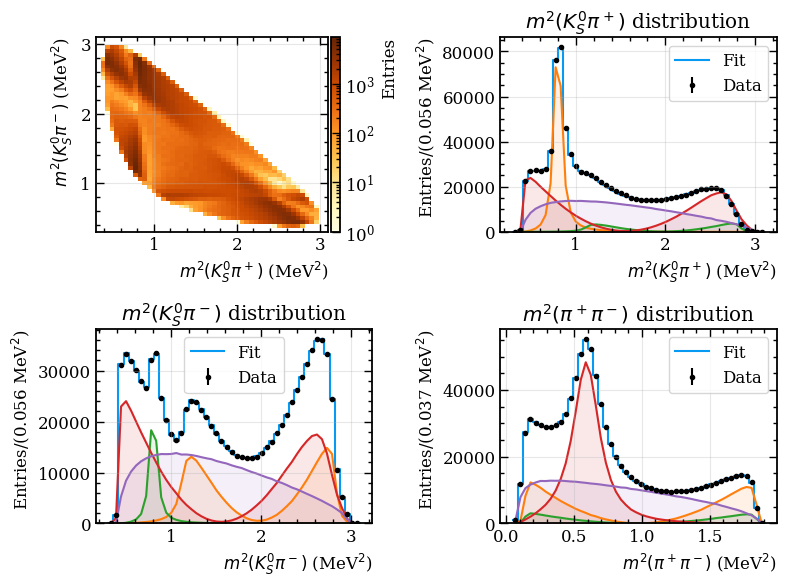

In [15]:
# Plot results
import matplotlib.pyplot as plt

tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))  # Single subplot on the figure

# Plot 1D histogram from the toy MC sample
tfp.plot_distr2d(
    toy_sample[:, 0],
    toy_sample[:, 1],
    bins=(50, 50),
    ranges=((0.3, 3.1), (0.3, 3.1)),
    fig=fig,
    ax=ax[0, 0],
    labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
    units=("MeV$^2$", "MeV$^2$"),
    log=True,
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 0],
    fitted_sample[:, 0],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[0, 1],
    label=r"$m^2(K_S^0\pi^+)$",
    units="MeV$^2$",
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 1],
    fitted_sample[:, 1],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[1, 0],
    label=r"$m^2(K_S^0\pi^-)$",
    units="MeV$^2$",
)

tfp.plot_distr1d_comparison(
    phsp.m2ac(toy_sample),
    phsp.m2ac(fitted_sample),
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.05, 1.9),
    ax=ax[1, 1],
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
)

# Show the plot
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)